In [1]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

from sklearn.metrics import make_scorer,accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Ridge, Lasso

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

In [2]:
# Basic stats
data = pd.read_csv('src/data.csv')

print("Number of rows : {}".format(data.shape[0]))
print()

print("Display of dataset: ")
display(data.head())
print()

print("Basics statistics: ")
data_desc = data.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*data.isnull().sum()/data.shape[0])

Number of rows : 5572

Display of dataset: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



Basics statistics: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2



Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

In [3]:
print("Dropping unecessairy variables ...")
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
print("done !")

Dropping unecessairy variables ...
done !


In [4]:
print('Shape of dataset before dropping duplicated rows :', data.shape)
print()
print('Return \'True\' if certain values of v2 column are duplicated : ', data['v2'].duplicated().any())

duplicate_v2 = data.duplicated(subset=['v2'])
if duplicate_v2.any():
    data = data.loc[~duplicate_v2]

print()
print('Shape of dataset after dropping duplicated rows :', data.shape)

Shape of dataset before dropping duplicated rows : (5572, 2)

Return 'True' if certain values of v2 column are duplicated :  True

Shape of dataset after dropping duplicated rows : (5169, 2)


In [5]:
data['word_count'] = data.v2.apply(lambda x : len(x.split(' ')))
data.head()

,v1,v2,word_count
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


Mean words in ham :  14.26
Mean words in spam :  23.73


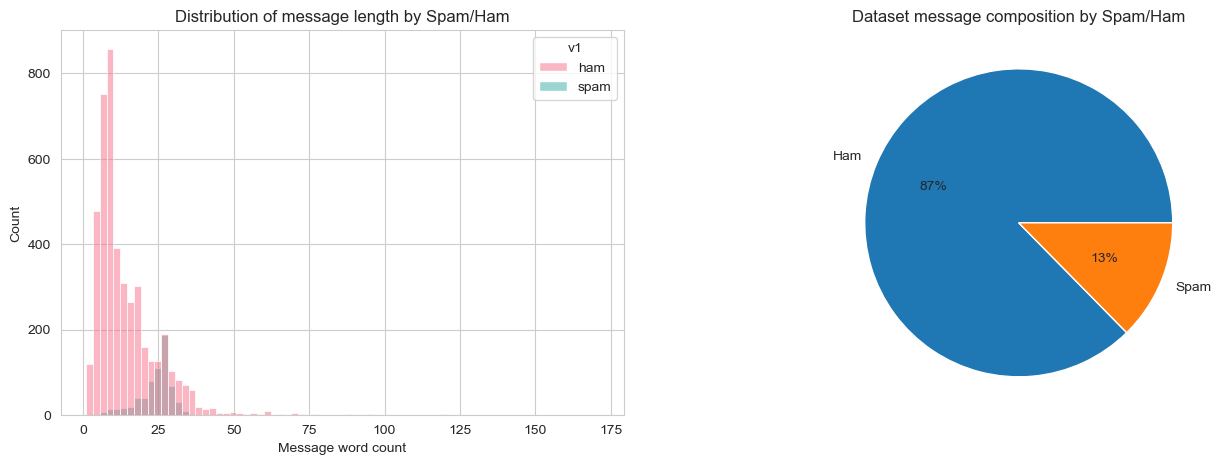

In [6]:
# Plot message length by spam/ham

print("Mean words in ham : ", round(data.groupby('v1')['word_count'].mean()[0],2))
print("Mean words in spam : ", round(data.groupby('v1')['word_count'].mean()[1],2))

sns.set_style("whitegrid")

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,5))
sns.histplot(data=data, 
             x="word_count",
             hue="v1",
             palette='husl',
             bins=75,
             ax=ax[0],
             legend=True).set_title('Distribution of message length by Spam/Ham')
ax[0].set_xlabel('Message word count')
ax[0].set_ylabel('Count')
colors = sns.color_palette('husl')

ax[1].pie(data.v1.value_counts(normalize=True), labels = ['Ham','Spam'], autopct='%0.f%%')
ax[1].set_title('Dataset message composition by Spam/Ham')
plt.show()

### Spam messages have a mean words greater than Ham message 

### PREPROCESSING

In [26]:
# We start by downloading spacy for the english language
!python3 -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [8]:
# Import Stop words 
from spacy.lang.en.stop_words import STOP_WORDS

In [9]:
#removes any non-alphanumeric characters, spaces, and apostrophes.
data["v2_clean"] = data["v2"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))

#replaces consecutive spaces with a single space, converts the text to lowercase and removes any leading or trailing whitespace.
data["v2_clean"] = data["v2_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())

#process each text in "v2_clean" as a series of tokens, make lemmatization and remove STOPWORDS
data["v2_clean"] = data["v2_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

data.head()


,v1,v2,word_count,v2_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,11,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah think usf live


In [10]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the dataset
spam_messages_spam = data[data['v1'] == 'spam']['v2_clean']

# Join all spam messages into a single string
spam_text_spam = " ".join(spam_messages_spam)

# Generate word cloud
wordcloud_spam = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOP_WORDS,
                min_font_size = 10).generate(spam_text_spam)

# Load the dataset
spam_messages_ham = data[data['v1'] == 'ham']['v2_clean']

# Join all spam messages into a single string
spam_text_ham = " ".join(spam_messages_ham)

# Generate word cloud
wordcloud_ham = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOP_WORDS,
                min_font_size = 10).generate(spam_text_ham)

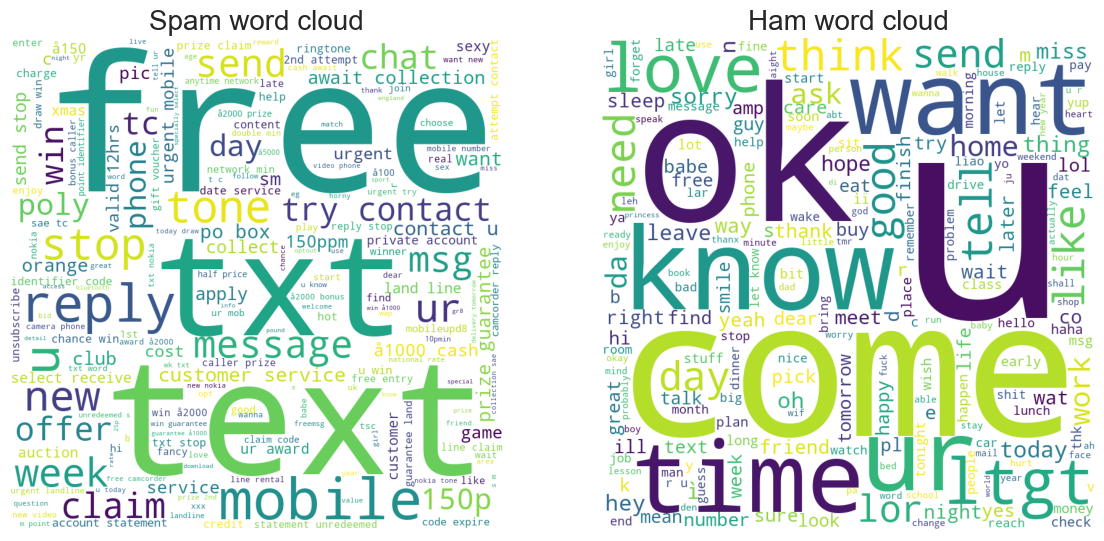

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
ax[0].imshow(wordcloud_spam)
ax[0].set_title('Spam word cloud', fontsize=20)
ax[1].imshow(wordcloud_ham)
ax[1].set_title('Ham word cloud', fontsize=20)
fig.set_facecolor("white")
ax[0].axis('off')
ax[1].axis('off')

plt.show()

### We can see that the most common word from both `Spam` and `Ham` messages are differents

In [12]:
#Lets create a label column that is a numerization of v1 column
data['label'] = data['v1'].replace({'ham': 0, 'spam': 1})
data.head()

,v1,v2,word_count,v2_clean,label
0,ham,"Go until jurong point, crazy.. Available only ...",20,jurong point crazy available bugis n great wor...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...,1
3,ham,U dun say so early hor... U c already then say...,11,u dun early hor u c,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah think usf live,0


In [14]:
#Lets change v2_clean type into str
mask = data.v2_clean.apply(lambda x: type(x)==str)
mask.value_counts()

v2_clean
True    5169
Name: count, dtype: int64

## BASE LINE : LogisticRegression

### Tokenization with Scikit-Learn

In [15]:
#converts a collection of text documents into a matrix of token counts, where each row represents a document, and each column represents a specific token (word or n-gram).
#The token_pattern=r'\b\w+\b' parameter in the CountVectorizer constructor ensures that the CountVectorizer will tokenize the text by extracting individual words, 
#considering only alphanumeric characters and ignoring any punctuation or special characters.
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')


print('Dividing into train and test sets...')
X_train, X_test, Y_train, Y_test = train_test_split(data.v2_clean, data.label, test_size = 0.2, random_state = 42, stratify=data.label)
print('... Done!')


vectorizer.fit(X_train)


X_train_df = vectorizer.transform(X_train)
X_test_df = vectorizer.transform(X_test)
print(type(X_train_df))

Dividing into train and test sets...
... Done!
<class 'scipy.sparse._csr.csr_matrix'>


In [18]:
# Create a Logistic Regression classifier object
model = LogisticRegression(max_iter=4000)

# Define the parameter grid
params = {
    'solver': ['saga', 'lbfgs'],
    'C' : [1000, 100, 40, 20, 10, 1, 0.1]

}
# Perform grid search using 5-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


gridsearch = GridSearchCV(estimator=model, param_grid=params, scoring='f1', n_jobs=-1, cv=cv)

# Fit the grid search to the data
gridsearch.fit(X_train_df, Y_train)

# Print the best parameters and best score and std
print("Best mean test score: %f , and best std test score: %f best using %s" % (gridsearch.best_score_, gridsearch.cv_results_['std_test_score'][gridsearch.best_index_], gridsearch.best_params_))

Best mean test score: 0.903029 , and best std test score: 0.019729 best using {'C': 10, 'solver': 'saga'}


In [19]:
LR_model = LogisticRegression(C= 10, solver= 'saga', max_iter=4000)
LR_model.fit(X_train_df, Y_train)
Y_train_pred = LR_model.predict(X_train_df)
Y_test_pred = LR_model.predict(X_test_df)

In [20]:
print("============= Training set ===============")
print(classification_report(Y_train, Y_train_pred))

print("============= Test set ===============")
print(classification_report(Y_test, Y_test_pred))

============= Training set ===============
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3613
           1       1.00      1.00      1.00       522

    accuracy                           1.00      4135
   macro avg       1.00      1.00      1.00      4135
weighted avg       1.00      1.00      1.00      4135

============= Test set ===============
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       903
           1       0.99      0.89      0.94       131

    accuracy                           0.98      1034
   macro avg       0.99      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034



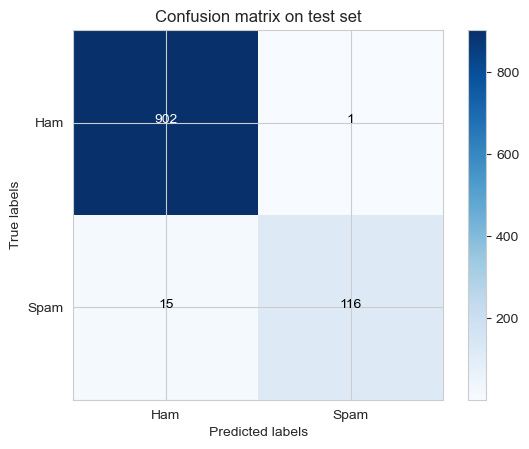

In [21]:
# Compute confusion matrix
cm = confusion_matrix(Y_test, Y_test_pred)
#cm = np.round(confusion_matrix(Y_test, Y_test_pred, normalize='true')*100, 2)

# Plot confusion matrix as heatmap
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.yticks([0, 1], ['Ham', 'Spam'])
plt.title('Confusion matrix on test set')
plt.colorbar()


# Add numbers on each block
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

#### Because in this case we have imbalanced classes, we will rather use `AUC-PR curve`. This metric measures the trade-off between precision and recall and is more suitable for imbalanced datasets where the positive class is rare. A higher `AUC-PR score` indicates better overall performance of the model.

recall : [1.         0.88549618 0.        ]
precision : [0.12669246 0.99145299 1.        ]
f1_score :  [0.2248927  0.93548387 0.        ]
Best threshold: 1.000
AUC-PR score: 0.946


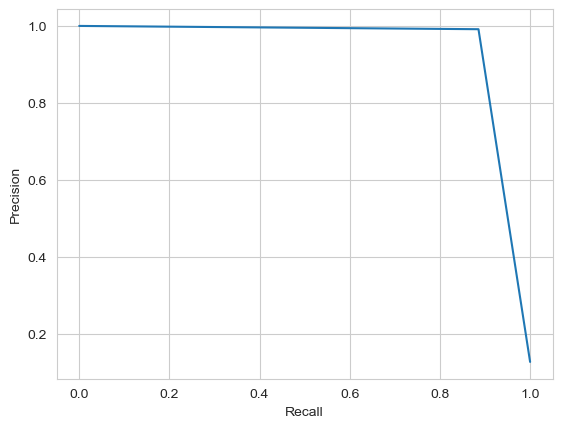

In [22]:
precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_pred)
pr_auc = auc(recall, precision)


f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

print('recall :', recall)
print('precision :', precision)
print('f1_score : ', f1_scores )
print("Best threshold: {:.3f}".format(best_threshold))


print("AUC-PR score: {:.3f}".format(pr_auc))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

#### For this LogisticRegression model, an `F1 score` of `1` on the train set and an `F1 score` of `0.94` on the test set suggests that the model is able to balance `precision` and `recall` fairly well in predicting the spam message. However, the model demonstrates a higher `precision` score compared to the `recall` score. This indicates that among the predictions made for spam messages, we can be confident at a rate of `99%` that they are indeed spam messages. However, when considering all the spam messages present in the dataset, the model is able to detect only `89%` of them.



## Word Embedding

### Tokenization with Tensorflow

In [23]:
# text tokenization
# instanciate the tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer() 

#update the internal vocabulary based on the text data provided to create a vocabulary index of unique words.
tokenizer.fit_on_texts(data.v2_clean)

#convert each text in the v2_clean column to a sequence of integers based on the vocabulary learned from the fit_on_texts step.
data["v2_encoded"] = tokenizer.texts_to_sequences(data.v2_clean)

data.head()

,v1,v2,word_count,v2_clean,label,v2_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,jurong point crazy available bugis n great wor...,0,"[3139, 210, 408, 485, 845, 31, 50, 261, 846, 7..."
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif u oni,0,"[9, 174, 486, 262, 1, 1320]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...,1,"[10, 336, 2, 698, 699, 38, 2075, 981, 460, 207..."
3,ham,U dun say so early hor... U c already then say...,11,u dun early hor u c,0,"[1, 113, 134, 2080, 1, 75]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah think usf live,0,"[663, 17, 605, 146]"


In [24]:
#Compute lenght of each sequence of integers
data["len_v2_encoded"] = data["v2_encoded"].apply(lambda x: len(x))
data = data[data["len_v2_encoded"]!=0]
print(data.shape)
data.head()

(5151, 7)


,v1,v2,word_count,v2_clean,label,v2_encoded,len_v2_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,jurong point crazy available bugis n great wor...,0,"[3139, 210, 408, 485, 845, 31, 50, 261, 846, 7...",14
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif u oni,0,"[9, 174, 486, 262, 1, 1320]",6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...,1,"[10, 336, 2, 698, 699, 38, 2075, 981, 460, 207...",22
3,ham,U dun say so early hor... U c already then say...,11,u dun early hor u c,0,"[1, 113, 134, 2080, 1, 75]",6
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah think usf live,0,"[663, 17, 605, 146]",4


In [25]:
#Add padding on the encoded sequences in the v2_encoded column in order to get the same sequence lenght 
#padding="post" specifies padding is added at the end (post) of each sequence.
v2_pad = tf.keras.preprocessing.sequence.pad_sequences(data.v2_encoded, padding="post")
print(v2_pad.shape)
v2_pad

(5151, 74)


array([[3139,  210,  408, ...,    0,    0,    0],
       [   9,  174,  486, ...,    0,    0,    0],
       [  10,  336,    2, ...,    0,    0,    0],
       ...,
       [8186, 1299, 8187, ...,    0,    0,    0],
       [ 108, 8188, 1450, ...,    0,    0,    0],
       [1839,  359,    0, ...,    0,    0,    0]], dtype=int32)

In [26]:
#divide dataset into train, val, and test
data_train, data_test, target_train, target_test = train_test_split(v2_pad, data.label.values, test_size=0.1, random_state=1,stratify=data.label.values)

data_train, data_val, target_train, target_val = train_test_split(data_train, target_train, test_size=0.1, random_state=1,stratify=target_train)

In [28]:
# creating tf datasets from our splits, shuffling and making batches
full_data_train = tf.data.Dataset.from_tensor_slices((data_train, target_train))
full_data_test = tf.data.Dataset.from_tensor_slices((data_test, target_test))
full_data_val = tf.data.Dataset.from_tensor_slices((data_val, target_val))


train_batch = full_data_train.shuffle(len(full_data_train)).batch(64)
test_batch = full_data_test.shuffle(len(full_data_test)).batch(64)
val_batch = full_data_val.shuffle(len(full_data_val)).batch(64)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [29]:
#test of one batch
email, detector = next(iter(train_batch))
print('email :', email)
print('detector :', detector)

email : tf.Tensor(
[[1515  225 4612 ...    0    0    0]
 [5986    0    0 ...    0    0    0]
 [ 386    7 7158 ...    0    0    0]
 ...
 [ 945  944   57 ...    0    0    0]
 [1714   34  101 ...    0    0    0]
 [ 197    8  230 ...    0    0    0]], shape=(64, 74), dtype=int32)
detector : tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0], shape=(64,), dtype=int64)


In [30]:
len(tokenizer.word_index)+1


8189

In [32]:
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 100
model = tf.keras.Sequential([
                  # Word Embedding Layer          
                  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=[email.shape[1],], name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Classic Dense Layer
                  tf.keras.layers.Dense(32, activation='relu'),
                  tf.keras.layers.Dense(16, activation='relu'),

                  # Output layer that using the sigmoid function.
                  tf.keras.layers.Dense(1, activation="sigmoid")

])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 100)           818900    
                                                                 
 global_average_pooling1d_1   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 32)                3232      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 822,677
Trainable params: 822,677
Non-trainable params: 0
________________________________________________

In [35]:
# initialize an instance of the Adam optimizer
optimizer= tf.keras.optimizers.legacy.Adam()

#configure the model for training
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])



In [33]:
#calculate and create a weight dictionary that assigns higher weights to less frequent labels and lower weights to more frequent labels. 
weights = 1/data.label.value_counts()
weights = weights * len(data)/2
weights = {index : values for index , values in zip(weights.index,weights.values)}
weights

{0: 0.57258781680747, 1: 3.944104134762634}

In [36]:
# Model training 
model.fit(train_batch,
          epochs=7, 
          validation_data=val_batch,
          class_weight=weights)

Epoch 1/7


2023-05-24 06:50:16.331724: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


66/66 [==============================] - 3s 33ms/step - loss: 0.6858 - binary_accuracy: 0.8274 - val_loss: 0.6346 - val_binary_accuracy: 0.8922
Epoch 2/7
66/66 [==============================] - 2s 28ms/step - loss: 0.6051 - binary_accuracy: 0.9600 - val_loss: 0.5297 - val_binary_accuracy: 0.9763
Epoch 3/7
66/66 [==============================] - 2s 27ms/step - loss: 0.3124 - binary_accuracy: 0.9808 - val_loss: 0.2068 - val_binary_accuracy: 0.9849
Epoch 4/7
66/66 [==============================] - 2s 26ms/step - loss: 0.1291 - binary_accuracy: 0.9887 - val_loss: 0.1013 - val_binary_accuracy: 0.9871
Epoch 5/7
66/66 [==============================] - 2s 25ms/step - loss: 0.0758 - binary_accuracy: 0.9933 - val_loss: 0.1049 - val_binary_accuracy: 0.9849
Epoch 6/7
66/66 [==============================] - 2s 26ms/step - loss: 0.0547 - binary_accuracy: 0.9947 - val_loss: 0.0502 - val_binary_accuracy: 0.9892
Epoch 7/7
66/66 [==============================] - 2s 25ms/step - loss: 0.0407 - binar

In [37]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=model.history.history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=model.history.history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()

In [38]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=model.history.history["binary_accuracy"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=model.history.history["val_binary_accuracy"],
                    mode='lines',
                    name='val_loss'))
fig.show()

In [39]:
test_pred_labels = model.predict(data_test)
test_pred_labels = test_pred_labels.reshape(-1)


preds = pd.DataFrame({'true':target_test,'pred':test_pred_labels})
preds['pred'] = round(preds['pred'])

print("\n========= test set ==========")
print(classification_report(preds.true, preds.pred))

17/17 [==============================] - 0s 4ms/step

========= test set ==========
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       451
           1       0.87      0.94      0.90        65

    accuracy                           0.97       516
   macro avg       0.93      0.96      0.94       516
weighted avg       0.98      0.97      0.98       516



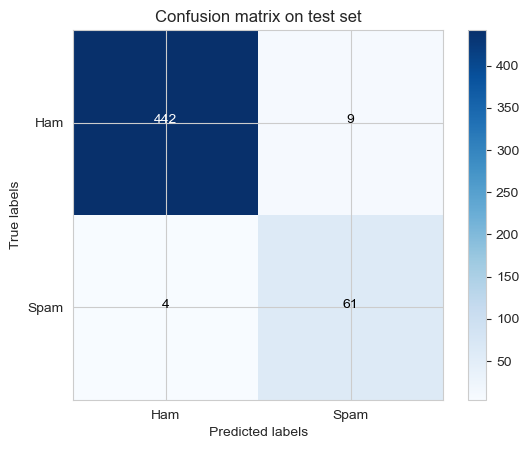

In [40]:
# Compute confusion matrix
cm = confusion_matrix(preds.true, preds.pred)

# Plot confusion matrix as heatmap
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.yticks([0, 1], ['Ham', 'Spam'])
plt.title('Confusion matrix on test set')
plt.colorbar()


# Add numbers on each block
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

recall : [1.         0.93846154 0.        ]
precision : [0.12596899 0.87142857 1.        ]
f1_score :  [0.22375215 0.9037037  0.        ]
Best threshold: 1.000
AUC-PR score: 0.909


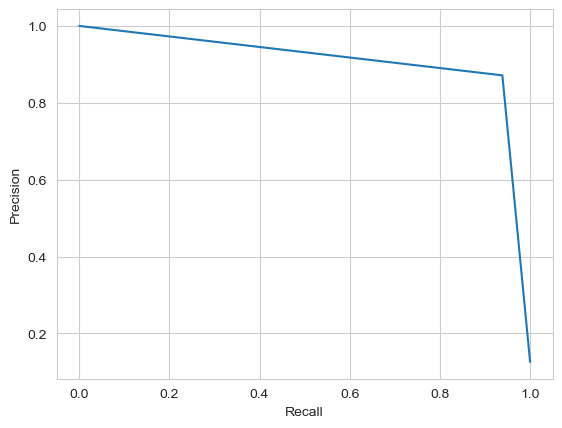

In [41]:
precision, recall, thresholds = precision_recall_curve(preds.true, preds.pred)
pr_auc = auc(recall, precision)


f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

print('recall :', recall)
print('precision :', precision)
print('f1_score : ', f1_scores )
print("Best threshold: {:.3f}".format(best_threshold))


print("AUC-PR score: {:.3f}".format(pr_auc))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

#### This time when using Word Embedding layer, the `F1 score` on the test set is lower than LogisticRegression one. However, this model demonstrates this time a lower `precision` score compared to the `recall` score. This indicates that among the predictions made for spam messages, we can be confident at a rate of `87%` that they are indeed spam messages. However, when considering all the spam messages present in the dataset, the model is able to detect only `94%` of them.

### The `AUC` of Word Embedding layer is lower compared to the LogisticRegression's `AUC`


## Transfert Learning

In [42]:
#loading pre-trained word embeddings
embedding_path = 'src/glove.6B.100d.txt'
embedding_dim = 100

#create empty dictionary to store the word embeddings.
embeddings_index = {}
with open(embedding_path, encoding='utf8') as f:
        for line in f:
            #removes any leading or trailing whitespaces from the line and then splits it into a list of values using whitespace as the delimiter. 
            # Each value represents either a word or a coefficient of the word embedding.
            values = line.strip().split()
            #assigning the first value in the values list (the word) to the variable word
            word = values[0]
            #the remaining values in the values list (the coefficients of the word embedding) are converted into a NumPy array of type 'float32'
            coefs = np.asarray(values[1:], dtype='float32')
            #add an entry to the embeddings_index dictionary, where the key is the word and the value is the corresponding word embedding coefficients.
            embeddings_index[word] = coefs



In [43]:
tokenizer.word_index

{'u': 1,
 '2': 2,
 'ur': 3,
 'come': 4,
 'know': 5,
 '4': 6,
 'good': 7,
 'ltgt': 8,
 'ok': 9,
 'free': 10,
 'like': 11,
 'want': 12,
 'send': 13,
 'time': 14,
 'day': 15,
 'love': 16,
 'think': 17,
 'text': 18,
 'tell': 19,
 'need': 20,
 'lor': 21,
 'home': 22,
 'today': 23,
 'txt': 24,
 'stop': 25,
 'reply': 26,
 'r': 27,
 'new': 28,
 'mobile': 29,
 'ask': 30,
 'n': 31,
 'hi': 32,
 'phone': 33,
 'da': 34,
 'sorry': 35,
 'ì': 36,
 'work': 37,
 'win': 38,
 'week': 39,
 'hope': 40,
 'miss': 41,
 'hey': 42,
 'wait': 43,
 'night': 44,
 'thing': 45,
 'oh': 46,
 'try': 47,
 's': 48,
 'wat': 49,
 'great': 50,
 'leave': 51,
 'meet': 52,
 'm': 53,
 'thank': 54,
 'number': 55,
 'claim': 56,
 'later': 57,
 'happy': 58,
 'way': 59,
 'feel': 60,
 'message': 61,
 'friend': 62,
 'dear': 63,
 'let': 64,
 'late': 65,
 'yeah': 66,
 'pls': 67,
 'find': 68,
 'right': 69,
 'babe': 70,
 'prize': 71,
 'd': 72,
 'e': 73,
 'tomorrow': 74,
 'c': 75,
 'yes': 76,
 'min': 77,
 'pick': 78,
 'sleep': 79,
 'cos': 80

In [46]:
# Prepare embedding matrix
#retrieving the word-to-index mapping from the tokenizer.
word_index = tokenizer.word_index

#calculating the total number of words in the tokenizer's vocabulary plus one.
num_words = len(word_index) + 1

#Creating empty matrix of shape (num_words, embedding_dim), where num_words represents the number of words in the vocabulary, 
# and embedding_dim represents the dimensionality of the word embeddings.
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    #retrieving the pre-trained word embedding vector for the current word from the embeddings_index dictionary.
    embedding_vector = embeddings_index.get(word)
    #checking if the embedding_vector is not None, indicating that the word has a pre-trained embedding available.
    if embedding_vector is not None:
        #assigning its embedding vector to the corresponding row (i) in the embedding_matrix.
        embedding_matrix[i] = embedding_vector

In [47]:
# Build model with pre-trained embeddings

#calculating the maximum sequence length of the padded sequences (v2_pad) 
max_seq_length = v2_pad.shape[1]

#initializing a sequential model object
model = tf.keras.models.Sequential()

#adding an embedding layer to the model.
model.add(tf.keras.layers.Embedding(num_words,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_seq_length,
                    trainable=False))

#adding an LSTM (Long Short-Term Memory) layer to the model with 32 units
model.add(tf.keras.layers.LSTM(32))

#adding a dense layer with a single unit and a sigmoid activation function 
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 100)           818900    
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 835,957
Trainable params: 17,057
Non-trainable params: 818,900
_________________________________________________________________


In [48]:
#configure the model for training
#using 'rmsprop' as optimizer
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])


In [49]:

model.fit(train_batch,
          epochs=15, 
          validation_data=val_batch,
          class_weight=weights)

Epoch 1/15
66/66 [==============================] - 4s 40ms/step - loss: 0.6194 - binary_accuracy: 0.6574 - val_loss: 0.4564 - val_binary_accuracy: 0.9418
Epoch 2/15
66/66 [==============================] - 2s 28ms/step - loss: 0.3695 - binary_accuracy: 0.9187 - val_loss: 0.2812 - val_binary_accuracy: 0.9569
Epoch 3/15
66/66 [==============================] - 2s 27ms/step - loss: 0.2920 - binary_accuracy: 0.9204 - val_loss: 0.2244 - val_binary_accuracy: 0.9461
Epoch 4/15
66/66 [==============================] - 2s 24ms/step - loss: 0.2422 - binary_accuracy: 0.9324 - val_loss: 0.1746 - val_binary_accuracy: 0.9397
Epoch 5/15
66/66 [==============================] - 2s 24ms/step - loss: 0.2141 - binary_accuracy: 0.9463 - val_loss: 0.2017 - val_binary_accuracy: 0.9397
Epoch 6/15
66/66 [==============================] - 2s 27ms/step - loss: 0.2031 - binary_accuracy: 0.9477 - val_loss: 0.1980 - val_binary_accuracy: 0.9418
Epoch 7/15
66/66 [==============================] - 2s 28ms/step - los

In [50]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=model.history.history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=model.history.history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()

In [51]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=model.history.history["binary_accuracy"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=model.history.history["val_binary_accuracy"],
                    mode='lines',
                    name='val_loss'))
fig.show()

In [52]:
test_pred_labels = model.predict(data_test)
test_pred_labels = test_pred_labels.reshape(-1)


preds = pd.DataFrame({'true':target_test,'pred':test_pred_labels})
preds['pred'] = round(preds['pred'])

print("\n========= test set ==========")
print(classification_report(preds.true, preds.pred))

17/17 [==============================] - 1s 17ms/step

========= test set ==========
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       451
           1       0.86      0.92      0.89        65

    accuracy                           0.97       516
   macro avg       0.92      0.95      0.94       516
weighted avg       0.97      0.97      0.97       516



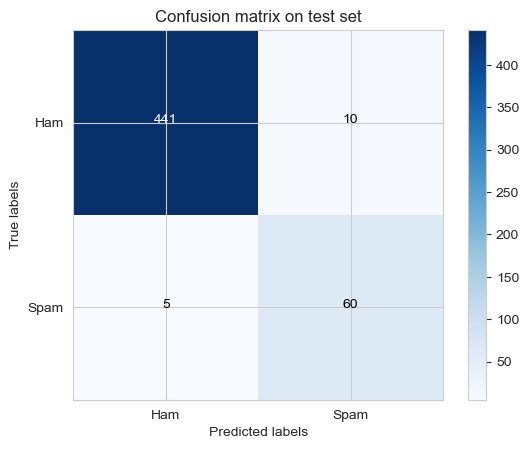

In [53]:
# Compute confusion matrix
cm = confusion_matrix(preds.true, preds.pred)

# Plot confusion matrix as heatmap
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.yticks([0, 1], ['Ham', 'Spam'])
plt.title('Confusion matrix on test set')
plt.colorbar()


# Add numbers on each block
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

recall : [1.         0.92307692 0.        ]
precision : [0.12596899 0.85714286 1.        ]
f1_score :  [0.22375215 0.88888889 0.        ]
Best threshold: 1.000
AUC-PR score: 0.895


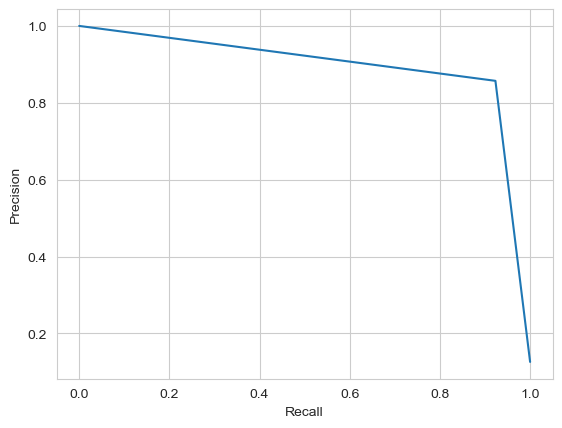

In [54]:
precision, recall, thresholds = precision_recall_curve(preds.true, preds.pred)
pr_auc = auc(recall, precision)


f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

print('recall :', recall)
print('precision :', precision)
print('f1_score : ', f1_scores )
print("Best threshold: {:.3f}".format(best_threshold))


print("AUC-PR score: {:.3f}".format(pr_auc))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Even with pre-trained model the performance is not better than LogisticRegression.